# Evaluating our WGAN

In [21]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [22]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 16, stride=1, padding=0),
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Loading the Pre-trained Model

  *   z_dim: the dimension of the noise vector
  *   image_size: the image size of the input to Inception_v3
  *   device: the device type

In [23]:
import os 
output_path = '/kaggle/input/gan-train-data/train'
# creating list of paths for images
image_list_train = []
for dirname, _, filenames in os.walk(output_path):
    for filename in filenames :
        path = os.path.join(dirname, filename)
        if path.find('flair') != -1 :
            image_list_train.append(path.replace('_flair.png',''))
image_list_train = [name for name in image_list_train if 'utre' not in name and 'ihms' not in name]
            
print('No of training Images', len(image_list_train))

No of training Images 3092


In [24]:
output_path = '/kaggle/input/gan-train-data/valid'
# creating list of paths for images
image_list_valid = []
for dirname, _, filenames in os.walk(output_path):
    for filename in filenames :
        path = os.path.join(dirname, filename)
        if path.find('flair') != -1 :
            image_list_valid.append(path.replace('_flair.png',''))
image_list_valid = [name for name in image_list_valid if 'utre' not in name and 'ihms' not in name]

print('No of validation Images', len(image_list_valid))

No of validation Images 181


In [25]:
image_list = image_list_train + image_list_valid

In [26]:
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

z_dim = 100
image_size = 299
device = 'cuda'

transform = A.Compose([
    A.Resize(image_size, image_size, cv2.INTER_LINEAR),
    ToTensorV2(),
])


class BrainDataset(Dataset) :
    
    def __init__(self, path_list, transform_img=None) :
        self.path_list = path_list
        self.transform = transform_img
        self.resize    = A.Resize(128, 128)
        
    def __len__(self) :
        return len(self.path_list)
    
    def __getitem__(self, idx) :
        img_path  = self.path_list[idx] + '_flair.png'
        
        img = cv2.imread(img_path, 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = self.resize(image=img)['image']
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img

torch.Size([3, 299, 299])


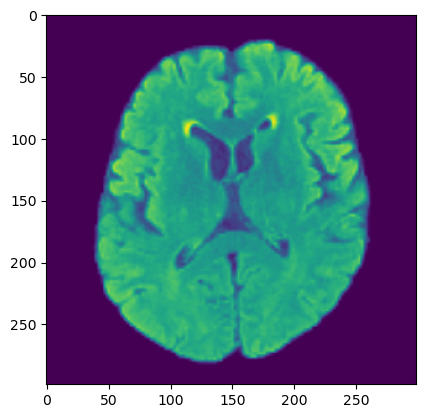

In [27]:
dataset = BrainDataset(image_list, transform)
img = dataset[208]
print(img.shape)
plt.imshow(img[0])

Load and Initialize our trained WGAN after the 900th epoch.

In [28]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"/kaggle/input/fid-gen/W900new_Gen.pt", map_location=torch.device(device))["model_state_dict"])
gen = gen.eval()

## Inception-v3 Network
Inception-V3 is a neural network trained on [ImageNet](http://www.image-net.org/) to classify objects. You may recall from the lectures that ImageNet has over 1 million images to train on. As a result, Inception-V3 does a good job detecting features and classifying images. Here, you will load Inception-V3 as `inception_model`.

<!--  
In the past, people would use a pretrained Inception network to identify the classes of the objects generated by a GAN and measure how similar the distribution of classes generated was to the true image (using KL divergence). This is known as inception score. 

However, there are many problems with this metric. Barratt and Sharma's 2018 "[A Note on the Inception Score](https://arxiv.org/pdf/1801.01973.pdf)" highlights many issues with this approach. Among them, they highlight its instability, its exploitability, and the widespread use of Inception Score on models not trained on ImageNet.  -->




In [29]:
from torchvision.models import inception_v3
inception_model = inception_v3(weights=None)
inception_model.load_state_dict(torch.load("/kaggle/input/fid-gen/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

## Fréchet Inception Distance

Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. Research has shown that deep convolutional neural networks trained on difficult tasks, like classifying many classes, build increasingly sophisticated representations of features going deeper into the network. For example, the first few layers may learn to detect different kinds of edges and curves, while the later layers may have neurons that fire in response to human faces.

In [30]:
inception_model.fc = torch.nn.Identity()

### Fréchet Distance 
Fréchet distance uses the values from the feature layer for two sets of images, say reals and fakes, and compares different statistical properties between them to see how different they are. Specifically, Fréchet distance finds the shortest distance needed to walk along two lines, or two curves, simultaneously. The most intuitive explanation of Fréchet distance is as the "minimum leash distance" between two points. Imagine yourself and your dog, both moving along two curves. If you walked on one curve and your dog, attached to a leash, walked on the other at the same pace, what is the least amount of leash that you can give your dog so that you never need to give them more slack during your walk? Using this, the Fréchet distance measures the similarity between these two curves.

The basic idea is similar for calculating the Fréchet distance between two probability distributions. You'll start by seeing what this looks like in one-dimensional, also called univariate, space.


#### Univariate Fréchet Distance
You can calculate the distance between two normal distributions $X$ and $Y$ with means $\mu_X$ and $\mu_Y$ and standard deviations $\sigma_X$ and $\sigma_Y$, as:

$$d(X,Y) = (\mu_X-\mu_Y)^2 + (\sigma_X-\sigma_Y)^2 $$

Pretty simple, right? Now you can see how it can be converted to be used in multi-dimensional, which is also called multivariate, space.

#### Multivariate Fréchet Distance
**Covariance**

To find the Fréchet distance between two multivariate normal distributions, you first need to find the covariance instead of the standard deviation. The covariance, which is the multivariate version of variance (the square of standard deviation), is represented using a square matrix where the side length is equal to the number of dimensions. Since the feature vectors you will be using have 2048 values/weights, the covariance matrix will be 2048 x 2048. But for the sake of an example, this is a covariance matrix in a two-dimensional space:

$\Sigma = \left(\begin{array}{cc} 
1 & 0\\ 
0 & 1
\end{array}\right)
$

The value at location $(i, j)$ corresponds to the covariance of vector $i$ with vector $j$. Since the covariance of $i$ with $j$ and $j$ with $i$ are equivalent, the matrix will always be symmetric with respect to the diagonal. The diagonal is the covariance of that element with itself. In this example, there are zeros everywhere except the diagonal. That means that the two dimensions are independent of one another, they are completely unrelated.

The following code cell will visualize this matrix.

**Formula**

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root. $\mathrm{Tr}$ refers to the trace, the sum of the diagonal elements of a matrix.

In [31]:
import scipy
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [32]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x - mu_y, p=2) + torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x @ sigma_y))

## Putting it all together
Apply FID to your generator from earlier.
<!-- This isn't exactly what FID is meant for, since inception scores expect a natural image, but it should give a rough idea of the diversity and quality of your images.  [TODO: move to bottom since image net is trained on nature (cat, dog) images, fidelity (quality)] -->

In [33]:
def preprocess(img):
    img = (img + 1.0) / 2.0
    img = (img * 255.0)
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    img = torch.cat((img, img, img), dim=1)
    return img

Then, you'll define a function to calculate the covariance of the features that returns a covariance matrix given a list of values:

In [34]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Finally, you can use the pre-trained Inception-v3 model to compute features of the real and fake images. With these features, you can then get the covariance and means of these features across many samples. 

First, you get the features of the real and fake images using the Inception-v3 model:

In [80]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 3200 # The total number of samples
batch_size = 32 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory

    for real_example in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
        real_samples = real_example.float()
        real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
        real_features_list.append(real_features)

        fake_samples = get_noise(len(real_example), z_dim).to(device)
        fake_samples = preprocess(gen(fake_samples))
        fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
        fake_features_list.append(fake_features)
        cur_samples += len(real_samples)
        if cur_samples >= n_samples:
            break

  0%|          | 0/100 [00:00<?, ?it/s]

Then, you can combine all of the values that you collected for the reals and fakes into large tensors:

In [81]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

And calculate the covariance and means of these real and fake features:

In [82]:
mu_fake = torch.mean(fake_features_all, 0)
mu_real = torch.mean(real_features_all, 0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [83]:
mu_fake.shape

torch.Size([2048])

At this point, you can also visualize what the pairwise multivariate distributions of the inception features look like!

In [117]:
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

#chose indices
import random
# indices = [random.randint(0, 2048) for _ in range(7)]
# print(indices)
fake_dist = MultivariateNormal(mu_fake, sigma_fake)
fake_samples = fake_dist.sample((1000,))
real_dist = MultivariateNormal(mu_real, sigma_real)
real_samples = real_dist.sample((1000,))
print(real_samples.shape)

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=range(0,2048))
df_real = pd.DataFrame(real_samples.numpy(), columns=range(0,2048))
# df_fake["is_real"] = "no"
# df_real["is_real"] = "yes"
# df = pd.concat([df_fake, df_real])
# # sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

[286, 765, 447, 457, 1978, 1409, 615]
torch.Size([1000, 2048])


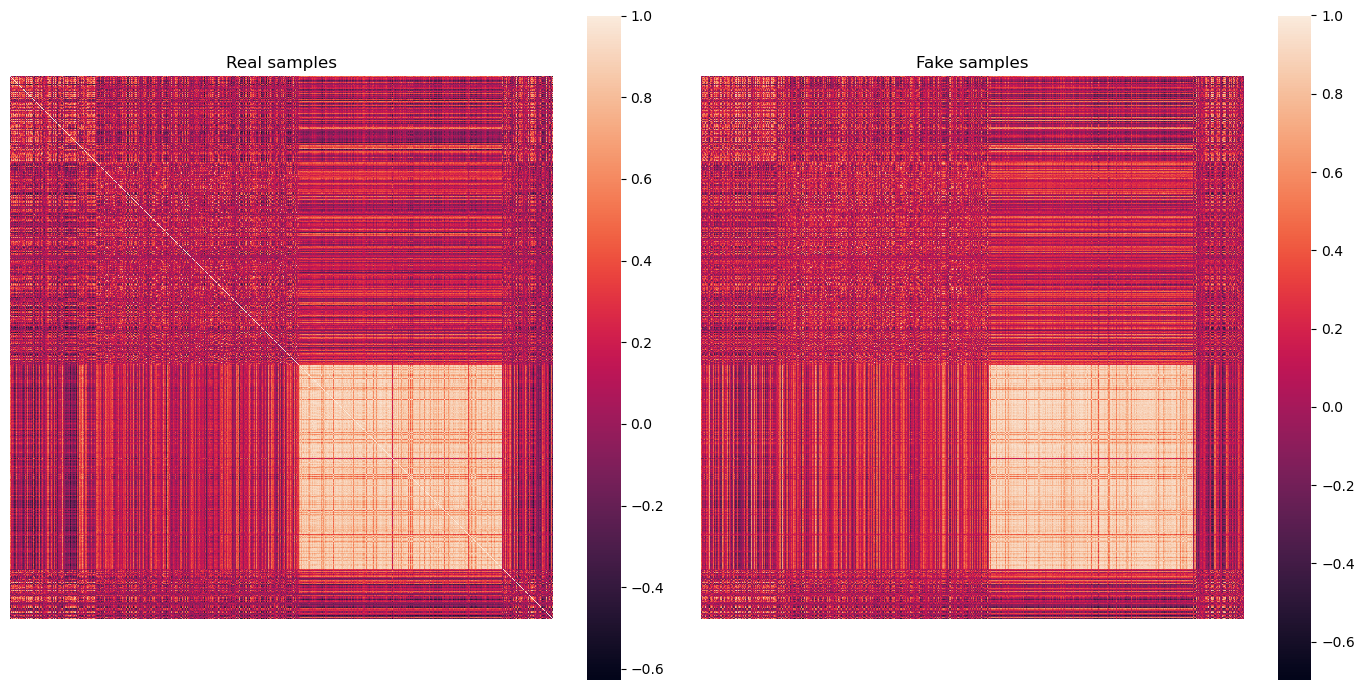

In [119]:
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_real = df_real.corr()
corr_fake = df_fake.corr()

# Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

# Plot heatmap for real samples
sns.heatmap(corr_real, ax=ax1, square=True)
ax1.set_title("Real samples")
ax1.set_xlabel("Features")
ax1.set_ylabel("Features")
ax1.axis('off')

# Plot heatmap for fake samples
sns.heatmap(corr_fake, ax=ax2, square=True)
ax2.set_title("Fake samples")
ax2.set_xlabel("Features")
ax2.set_ylabel("Features")
ax2.axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [93]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

134.41847229003906
